In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import time
import math
import emoji
import re
import string

BASE_DIR = "../"
DATA_DIR = "data/orig_data"
MEDIA_FILE = "20190610_tagged_media.csv"
PRODUCTS_FILE = "20190610_product_labels.csv"
MAX_WORDS_IN_CAPTION = 40

media_path = os.path.join(BASE_DIR, DATA_DIR, MEDIA_FILE)
products_path = os.path.join(BASE_DIR, DATA_DIR, PRODUCTS_FILE)
image_dir = os.path.join(BASE_DIR, 'images')

media = pd.read_csv(media_path)
products = pd.read_csv(products_path)

In [2]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32797 entries, 0 to 32796
Data columns (total 9 columns):
product_id                  32797 non-null int64
product_name                32797 non-null object
brand_name                  32797 non-null object
brand_instagram_username    32797 non-null object
main_category               32797 non-null object
sub_category                32694 non-null object
product_category            31893 non-null object
product_page_url            22395 non-null object
product_image_url           27404 non-null object
dtypes: int64(1), object(8)
memory usage: 2.3+ MB


In [3]:
products.main_category.unique()

array(['color cosmetics', 'skincare', 'accessories', 'fragrance', 'nail',
       'bath body', 'hair', 'inner beauty'], dtype=object)

In [4]:
a=products[products['main_category'] == 'hair']
print(a.sub_category.unique())
b=a[a['sub_category'] == 'treat'].product_category.unique()
print(b)

['style' 'cleanse' 'treat' 'hair tools' 'hair accessories']
['hair treatments' 'hair mask' 'leave-in conditioner' 'hair primer']


## Fill in the missing values

In [5]:
# For products
values_to_fill = {'sub_category': 'unclear', 'product_category': 'unclear', 'product_page_url': 'none', 
                  'product_image_url': 'none'}
products.fillna(value = values_to_fill, inplace = True)

# For media
values_to_fill = {'media_caption': 'no caption', 'media_type': 'missing', 'caption_type': 'missing'}
media.fillna(value = values_to_fill, inplace = True)

## Clear data, Remove the products with unclear categories, combine into new classes

In [6]:
# To reduce the number of classes, for balanced distribution
# remove products with unclear categories
categories = ["sub_category", "product_category"]
indices_to_drop = []
for ctgr in categories:
    indices_to_drop.extend(list(products[products[ctgr] == 'unclear'].index))

indices_to_drop = set(indices_to_drop)    
print("number of product IDs to drop is %d" %len(indices_to_drop))
old_num = len(products)
products.drop(indices_to_drop, axis=0, inplace=True)
new_num = len(products)
print("number of products before and after removing unclear categories are %d and %d" %(old_num, new_num))

number of product IDs to drop is 904
number of products before and after removing unclear categories are 32797 and 31893


## Some tagged products IDs are not in product list, delete them from media data frame

In [7]:
productIDs_in_inventory = products.product_id.unique()
productIDs_in_media = media.tagged_product_id.unique()
not_in_inventory = set(filter(lambda x: x not in productIDs_in_inventory, productIDs_in_media))
old_num = len(media)
media = media[~media.tagged_product_id.isin(not_in_inventory)]
new_num = len(media)
print("number of social media posts before and after are %d and %d" %(old_num, new_num))

number of social media posts before and after are 241917 and 237024


## Some social media images are not availale, exclude these posts for now. All downloadable images were stored locally in "images" folder

In [8]:
good_shortCodes = set([filename.split('.')[0] for filename in os.listdir(image_dir)])
media = media[media.media_shortcode.isin(good_shortCodes)]
print("number of images available for traning is %d" %len(good_shortCodes))
print("number of social media posts with associated images is %d" %len(media))

number of images available for traning is 135374
number of social media posts with associated images is 224714


## Delete the products that are not tagged in the media file, as they are not going to be learned anyway

In [9]:
productIDs_in_media = media.tagged_product_id.unique()
products = products[products.product_id.isin(productIDs_in_media)]
num_products = products.product_id.nunique()
print("The number of products in the inventory now is %d" %num_products)

The number of products in the inventory now is 26273


# Place the products into different classes
## Products -> Main Category -> Sub Category -> Product Category

In [10]:
#Put products into different bins based on product attributes.
#Products -> Main Category -> Sub Category -> Product Category
productID_classID = {}
className_classID = {} # index each class
className_productID = defaultdict(list) # store the productIDs in corresponding classes
curr_num_classes = 0

# map productID to class ID
for idx, row_data in products.iterrows():
    class_name = ':'.join([row_data.main_category, row_data.sub_category, 
                           row_data.product_category])
    if class_name not in className_classID:
        className_classID[class_name] = curr_num_classes
        curr_num_classes += 1
    
    product_ID, classID = row_data.loc['product_id'], className_classID[class_name]
    productID_classID[product_ID] = classID
    className_productID[class_name].append(product_ID)
    
#reverse mapping, class ID -> class name
classID_className = {value: key for key, value in className_classID.items()}

## Add another column in media data frame, for fine cagegories

In [11]:
labels = []
for idx, row_data in media.iterrows():
    productID = row_data.tagged_product_id
    classID = productID_classID[productID]
    labels.append(classID)
media['class_ID'] = labels

## Show only classes with more than 1131 mentions in media: significant imbalance

In [12]:
classID_numMentions = defaultdict(int)
className_numMentions = defaultdict(int)
for idx, row_data in media.iterrows():    
    classID = row_data.class_ID
    className = classID_className[classID]
    classID_numMentions[classID] += 1
    className_numMentions[className] += 1

72
40
median of number of products in each product category is: 4007


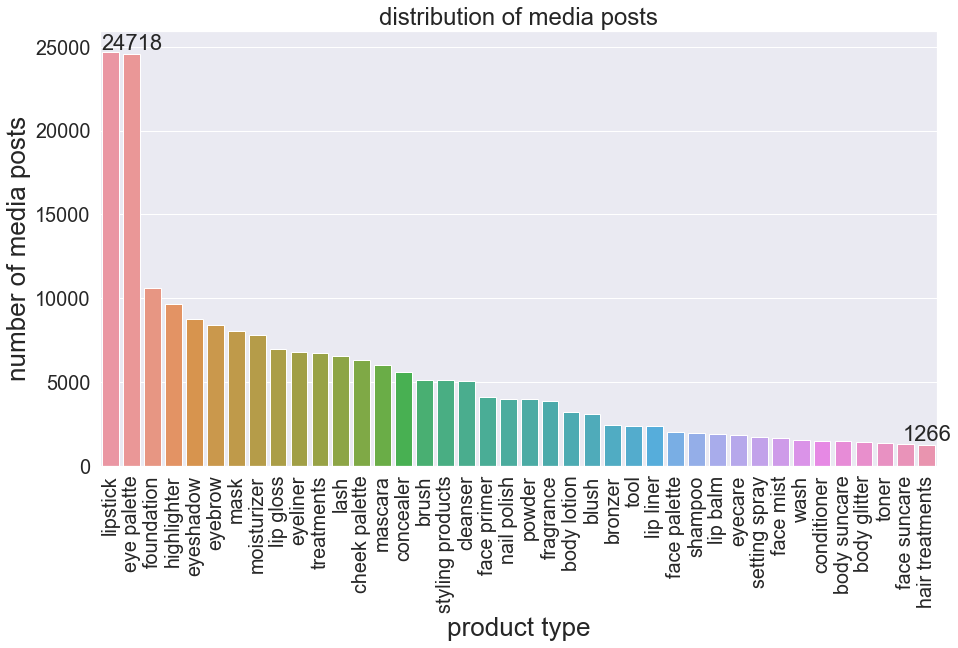

In [13]:
print(len(className_numMentions))
className_mentions = [[key, val] for key, val in className_numMentions.items()]
className_mentions.sort(key = lambda x : x[1], reverse = True)
   
distribution = [i for i in className_mentions if i[1] > 1131]

print(len(distribution))
#for i in distribution:
#    print(i)
# 
med_num = np.median(np.array([i[1] for i in distribution]))
print("median of number of products in each product category is: %d" %med_num)
classes = [i[0].split(':')[2]for i in distribution]
sns.set(font_scale = 1.8)
plt.figure(figsize=(15,8))
ax= sns.barplot(classes, [i[1] for i in distribution])
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.title("distribution of media posts", fontsize=24)
plt.ylabel('number of media posts', fontsize=26)
plt.xlabel('product type', fontsize=26)

##adding the text labels for max and min numbers
rects = [ax.patches[1], ax.patches[-1]]
labels = [distribution[0][1], distribution[-1][1]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom', fontsize=22)

## Delete products with less than 1131 mentions in media

In [14]:
classNames_to_keep = [i[0] for i in distribution]
productIDs_to_keep = []
for className in classNames_to_keep:
    productIDs_to_keep.extend(className_productID[className])
print(len(productIDs_to_keep))

# update produtcts data frame
products = products[products.product_id.isin(productIDs_to_keep)]

23836


## Delete corresponding media posts

In [15]:
old_num = len(media)
media = media[media.tagged_product_id.isin(productIDs_to_keep)]
new_num = len(media)
print("number of social media posts before and after are %d and %d" %(old_num, new_num))

number of social media posts before and after are 224714 and 213390


## caption cleaning
### adopted from CherryPick cp_media_processing repo

In [16]:
# build word : words included in GloVe
GloVe_words = set()
with open(os.path.join(BASE_DIR, 'glove.6B/glove.6B.50d.txt')) as f:
    for line in f:
        word = line.split()[0]
        GloVe_words.add(word)

In [17]:
def cleaner(text):
    # remove punctuation
    remove_punct = str.maketrans('', '', string.punctuation.replace('#', ''))
    text = text.translate(remove_punct).lower()
    return text

def remove_emoji(string):
    emojies = list(emoji.UNICODE_EMOJI)
    emojies = '|'.join((emojies))
    emojies = emojies.replace("|*","")
    otherchar= "|«"+"|»"+"|•"+"|•••"+"|••••"+"|♡"+"|⚬"+"|✓"+"|・"+"|ㅡ"+"|🇵🇭"+"|🇦🇺"+"|🇦🇺"+"|🇧🇷"+"|🇨🇦"+"|🇩🇪"+"|🇪🇸"+"|🇫🇷"+"|🇬🇧"+"|🇮🇹"+"|🇲🇽"+"|🇵🇭"+"|🇺🇸"+"|🇷🇺"+'|™'+'|®'+"|🏻🏼🏽🏾🏿"+"|🏻‍"+"|🏻"+"|🏼‍️"+"|🏼️"+"|🏽"+"|🏾"+'|’'+'|‘'+'|“'+'|”'+'|–'+'|—'+'|—'+"|'"+'|"'
    emojies += otherchar
    return re.sub('  ', ' ', re.sub(emojies,'', string))

def cleanunderscore(s):
    s = s.replace('_', '')
    return s

def normalize(s):
    """
    Given a text, cleans and normalizes it.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('#', ' mention ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

def isInGlove(s):
    """ Test if a string consists only of lower-case English words"""
    for char in s:
        if char not in string.ascii_lowercase:
            return False
    return True

def keepGloVeWords(s):
    """ Further process captions, only keep first MAX_WORDS_IN_CAPTION words found in GloVe.
        Probaly not too useful to embed those random words in captions, since most of them just appear once
        and contain no semantics.
    """
    individual_words = s.split()
    res = []
    for word in individual_words:
        if word in GloVe_words:
            res.append(word)
        if len(res) == MAX_WORDS_IN_CAPTION:
            break
    return " ".join(res)

In [18]:
captions = media.media_caption
captions = captions.astype(str).apply(remove_emoji).apply(cleaner).apply(cleanunderscore).apply(normalize).apply(keepGloVeWords)
media['media_caption'] = captions


In [19]:
media.fillna(value = {'media_caption': 'no caption'}, inplace = True)

## Save clean datasets to CSV

In [20]:
# re-set index
#products.reset_index(drop=True, inplace=True)
#media.reset_index(drop=True, inplace=True)

In [21]:
media.to_csv(BASE_DIR + "/data/imbalanced_media.csv", index=False)
products.to_csv(BASE_DIR + "/data/imbalanced_products.csv", index=False)